### Описание проекта:

Задача для маркетингового аналитика развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.


# Шаг 1. Загрузка и подготовка данных к анализу

1.1 Импортируем библиотеки

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from datetime import datetime, timedelta

Загружаем данные


In [4]:
visits = pd.read_csv('visits_info_short.csv')
orders = pd.read_csv('orders_info_short.csv')
costs = pd.read_csv('costs_info_short.csv')

In [5]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [6]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [7]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


1.2 Преобработка данных

Названия колонок не в "змеином" регистре и есть заглавные буквы. Приведу все к одному виду

In [8]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]
costs.columns = [x.lower().replace(' ', '_') for x in costs.columns.values]


visits.head(5)
orders.head(5)
#costs.head(5)

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Теперь названия колонок в нужном регистре. Проверяю все таблицы, вызвав метод head()

Приведу тип данных в датах к  datetime

In [9]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])
visits.info()
#orders.info()
#costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


Тип данных в нужных колонках был изменен. Для проверки вызываю метод info()

Проверка на дубликаты

In [10]:
visits.duplicated().sum()

0

In [11]:
orders.duplicated().sum()

0

In [12]:
costs.duplicated().sum()

0

Дубликатов нет

**Общий вывод по Шагу 1**

Были выгружены и рассмотрены данные трех таблиц. Потребовалась предобработка данных и она была проведена по следующим этапам:
- Изменение регистра в названиях колонок
- Изменений типа данных в колонках с датами 
- Проверка на дубликаты


# Шаг 2. Функции для расчета и анализа LTV, ROI, удержания и конверсии

Вводим функции

In [13]:
# функция для создания пользовательских профилей
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
 
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
 
    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
 
    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
 
    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles



In [14]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time


In [15]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time


In [16]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )


In [17]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df


In [18]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()


In [19]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 


In [20]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

**Общий вывод по Шагу 2**

Были введены функции:
- get_profiles() - для создания пользовательских профилей
- get_retention() - для расчета удержания
- get_conversion() - для расчета конверсии
- get_ltv() - для расчета LTV и ROI
- filter_data() - для сглаживания датафрейма
- plot_retention() - для визуализации удержания
- plot_conversion() - для визуализации конверсии
- plot_ltv_roi() - для визуализации LTV и ROI

# Шаг 3. Исследовательский анализ данных

1) Построить профили пользователей. 
Определить минимальную и максимальную дату привлечения пользователей.

2) Выяснить:

Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?.

1.1 Строим пользовательские профили с помощью функции get_profiles

In [21]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
profiles = get_profiles(visits, orders, costs)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


150008 пользовательских профилей. Есть данные о первом посещении и источнике, с которого пользователь пришел в приложение, устройстве, которое используется, и стране. В колонке payer в значении True/False указано является или нет пользователь покупателем.

1.2 Определение минимальной и максимальной даты

In [22]:
profiles['first_ts'].min()

Timestamp('2019-05-01 00:00:41')

In [23]:
profiles['first_ts'].max()

Timestamp('2019-10-27 23:59:04')

Минимальная и максимальная дата привлечения пользователей в отчете - 1 мая 2019 и 27 октября 2019 соответственно

2.1 Таблица количество пользователей и доли платящих по странам

Построим таблицу с группировкой по странам, показывающую количество пользователей и долю покупателей из каждой страны.

In [24]:
pd.set_option('display.float_format', '{:.2f}'.format)
profiles.groupby('region').agg({'user_id':'nunique','payer':'mean'}).sort_values(by='payer', ascending=False)


,user_id,payer
region,,
United States,100002,0.07
Germany,14981,0.04
UK,17575,0.04
France,17450,0.04


По количеству пользователей с большим отрывом лидирует США. По доле платящих также США, однако отрыв не такой сильный (на 2% больше Германии). У Германии при этом меньше всего пользователей - 14981. У Франции и Великобритании почти одинаковое количество пользователей (17450 и 17575), как и их доли платящих - 3%. На данной этапе можно сделать предположение, что у Германии высокая конверсия пользователя в покупателя.

2.2 Таблица количество пользователей и доли платящих по названию устройства

In [25]:
profiles.groupby('device').agg({'user_id':'nunique','payer':'mean'}).sort_values(by='payer', ascending=False)

,user_id,payer
device,,
Mac,30042,0.06
iPhone,54479,0.06
Android,35032,0.06
PC,30455,0.05


Что же касается устройств, с которых пользователи заходят в приложение, то по количеству пользователей лидирует iPhone - 54479, далее Android - почти на 30% меньше по пользователям(35032), Mac и PC примерно одинаково - чуть больше 30т. По покупателям при этом картина другая: по 6% у Mac и iPhone, по 5% у Android и PC 

2.3 Таблица количество пользователей и доли платящих по каналу привлечения

In [26]:
profiles.groupby('channel').agg({'user_id':'nunique','payer':'mean'}).sort_values(by='payer', ascending=False)

,user_id,payer
channel,,
FaceBoom,29144,0.12
AdNonSense,3880,0.11
lambdaMediaAds,2149,0.10
TipTop,19561,0.10
RocketSuperAds,4448,0.08
WahooNetBanner,8553,0.05
YRabbit,4312,0.04
MediaTornado,4364,0.04
LeapBob,8553,0.03


По доле покупателей в тройке лидеров FaceBoom, AdNonSense и lambdaMediaAds. По количеству пользователей - organic, то есть пользвоатели пришли в приложение без привлечения с какого-то ресурса, далее FaceBoom - 29144 и TipTop - 19561

Дополнение: Во всех трех таблицах сортировка по доле покупателей. Можно отдельно посмотреть графики по количеству пользователей в динамике

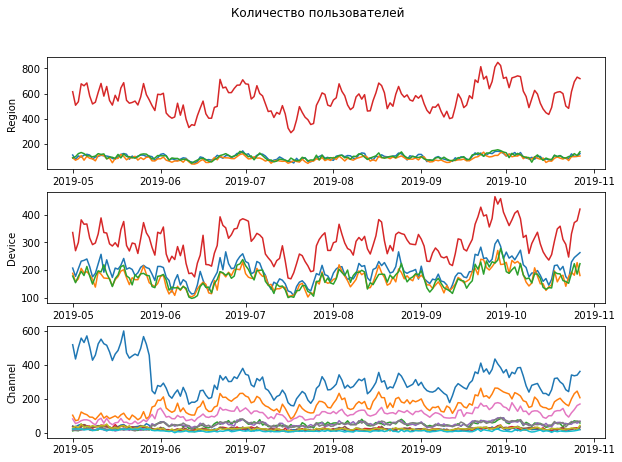

In [27]:
fig, (ax1,ax2, ax3) = plt.subplots(3, figsize=(10,7))
fig.suptitle('Количество пользователей')

ax1.plot(profiles.pivot_table(
    index='dt', #дата первых посещений
    columns='region', #страна
    values='user_id',  # ID пользователей
    aggfunc='nunique', # подсчёт уникальных значений
))
ax2.plot(profiles.pivot_table(
    index='dt',  # даты первых посещений
    columns='device',  # устройство
    values='user_id',  # ID пользователей
    aggfunc='nunique',  # подсчёт уникальных значений
)) 
ax3.plot (profiles.pivot_table(
    index='dt',  # даты первых посещений
    columns='channel',  # источники переходов
    values='user_id',  # ID пользователей
    aggfunc='nunique',  # подсчёт уникальных значений
))
ax1.set(ylabel='Region')
ax2.set(ylabel='Device')
ax3.set(ylabel='Channel')
plt.show()

Графики дополняют цифры. Видно, что у США большой отрыв по количеству пользователей, по устройствам iPhone явно отличается. А вот график с каналами показывает, что organic был наиболее активен в мае, а затем динамика похожа на остальные каналы.

**Общий вывод по Шагу 3**

При проведении исследовательского анализа стало ясно, что:
1) Пользователи приходят из США, Великобритании, Франции и Германии. Самая большая доля платящих пользователей приходится на США

2) Из устройств используются iPhone, Mac, Android и PC. БOльшая доля платящих приходится на iPhone и Mac - по 6%. Это на один процент больше, чем PC и Android

3) Привлечение пользователей шло по 10 каналам. Наибольшие доли платящих у FaceBoom, AdNonSense и lambdaMediaAds. Значительная дол пользователей приходит вообще без привлечения (organic), однако при этом у этого канала самая малая доля платящих клиентов. 

# Шаг 4. Маркетинг

Нужно выяснить:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

1.1 Рсчет общей суммы трат на рекламу

In [28]:
ad_total = costs['costs'].sum()
round(ad_total)

105497

Всего на рекламу за исследуемый период потрачено более 105 т

1.2 Построим таблицу затрат по источникам

In [29]:
costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Больше всего ушло на оплату рекламы в TipTop- 54751, на FaceBoom меньше почти на 30% (32455). На AdNonSense и lambda, котоые вместе с FaceBoom приносят приличные доли покупателей, приходится 3911 и 1557 соответственно. Полагаю предварительно, что по этим двум каналам будет окупаемость рекламы.

1.3 График затрат в динамике по датам

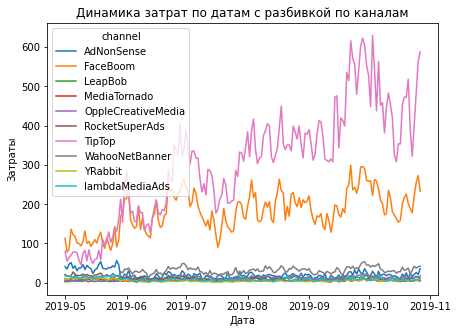

In [30]:
costs.pivot_table(
    index='dt', #дата
    columns='channel',  # канал
    values='costs',  # траты
    aggfunc='sum',  # подсчёт суммы
).plot(figsize=(7,5))
plt.title('Динамика затрат по датам с разбивкой по каналам')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

Побробнее рассмотрим нижную часть графика 

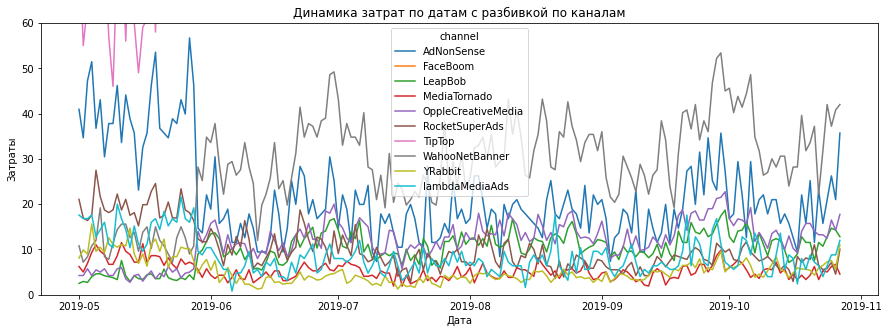

In [31]:
costs.pivot_table(
    index='dt', #дата
    columns='channel',  # канал
    values='costs',  # траты
    aggfunc='sum',  # подсчёт суммы
).plot(figsize=(15,5))
plt.ylim(0,60)
plt.title('Динамика затрат по датам с разбивкой по каналам')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

График показывает, что в динамике траты на рекламу в AdNonSense и lambda были примерно одинаковые, и где-то даже снижались, а траты на рекламу в FaceBoom со временем росли (в мае - 100, к ноябрю уже более 200).Однако самая большая динамика у TipTop (в мае чуть меньше 100, а к ноябрю уже почти 600)

2.1 Расчет среднего CAC на одного пользователя

In [32]:
round(profiles['acquisition_cost'].mean(),2)

0.7

В среднем на привлечение одного пользователя уходит 0.7

2.2 Средняя стоимость привлечения одного клиента по каналам

In [33]:
profiles.groupby('channel').agg({'acquisition_cost':'mean'}).sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


В среднем на привлечение клиента больше всего уходит на платформе TipTop (2.8). Его среднее больше, чем в два раза превышает ближайших FaceBoom и AdNonSense (1.11 и 1 соответственно). Близкий к общему среднему показывает CAC на канале lambdaMediaAda - 0.72

**Общий вывод по Шагу 4**

За исследуемый период было потрачено более 105т на рекламу. Львиную долю из них забрали два канала 
- TipTop	54751.30
- FaceBoom	32445.60

Остальное распределилось между 8-ю каналами от 5 до 0.9 т.
По указанным двум каналам расходы на рекламу в течение исследуемого периода росли. FaceBoom показал более чем двукратный рост, TipTop - шестикратный (за период расходы выросли в 6 раз). По остальным каналам, включая AdNonSense и lambdaMediaAds расходы практически не менялись (значения в диапазоне от 0 до 50)

В среднем на привлечение одного клиента уходит 0.7, а по каналам больше всего на TipTop (2.8), при этом значительно меньше расходы в среднем на других каналах: FaceBoom(1.1), AdNonSense(1.0), lambdaMedia(0.7)

# Шаг 5. Окупаемость рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализировать общую окупаемость рекламы;
- Проанализировать окупаемость рекламы с разбивкой по устройствам;
- Проанализировать окупаемость рекламы с разбивкой по странам;
- Проанализировать окупаемость рекламы с разбивкой по рекламным каналам.

Ответить на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

**1.1 Общая окупаемость рекламы**

Для посчета вызовем функцию get_ltv(), которая посчитает LTV, CAC, ROI, а также составит таблицы для графиков динамики. Для построения графика - функция plot_ltv_roi(). Перезапишем переменную profiles, сохраним всех неорганических пользователей

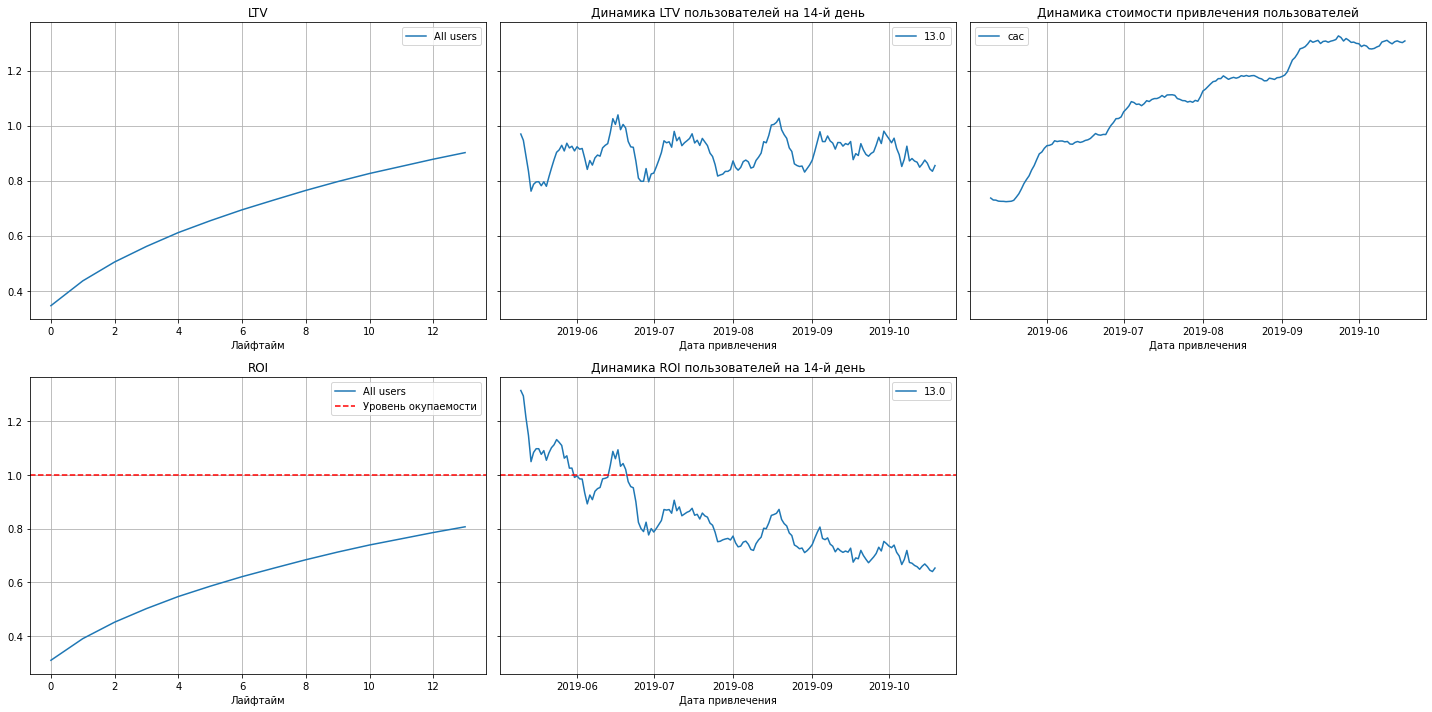

In [34]:

profiles['dt'] = pd.to_datetime(profiles['dt']).dt.date
profiles['first_ts'] = pd.to_datetime(profiles['first_ts'])

profiles = profiles.query('channel != "organic"')

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=10)

График LTV выглядит нормально - плавный рост, также как и ROI показывает рост в целом, окупаемость на 80%, то есть пока не окупается
 - В динамике ROI показывает сильное падение с мая по июль, расходы при этом все время растут плавно
 
 Есть проблемы. Нужно посмотреть подробнее по каналам и по странам

**1.2 Окупаемость рекламы с разбивкой по устройствам**

Снова применим функцию get_ltv() и plot, указав в аргументах устройство

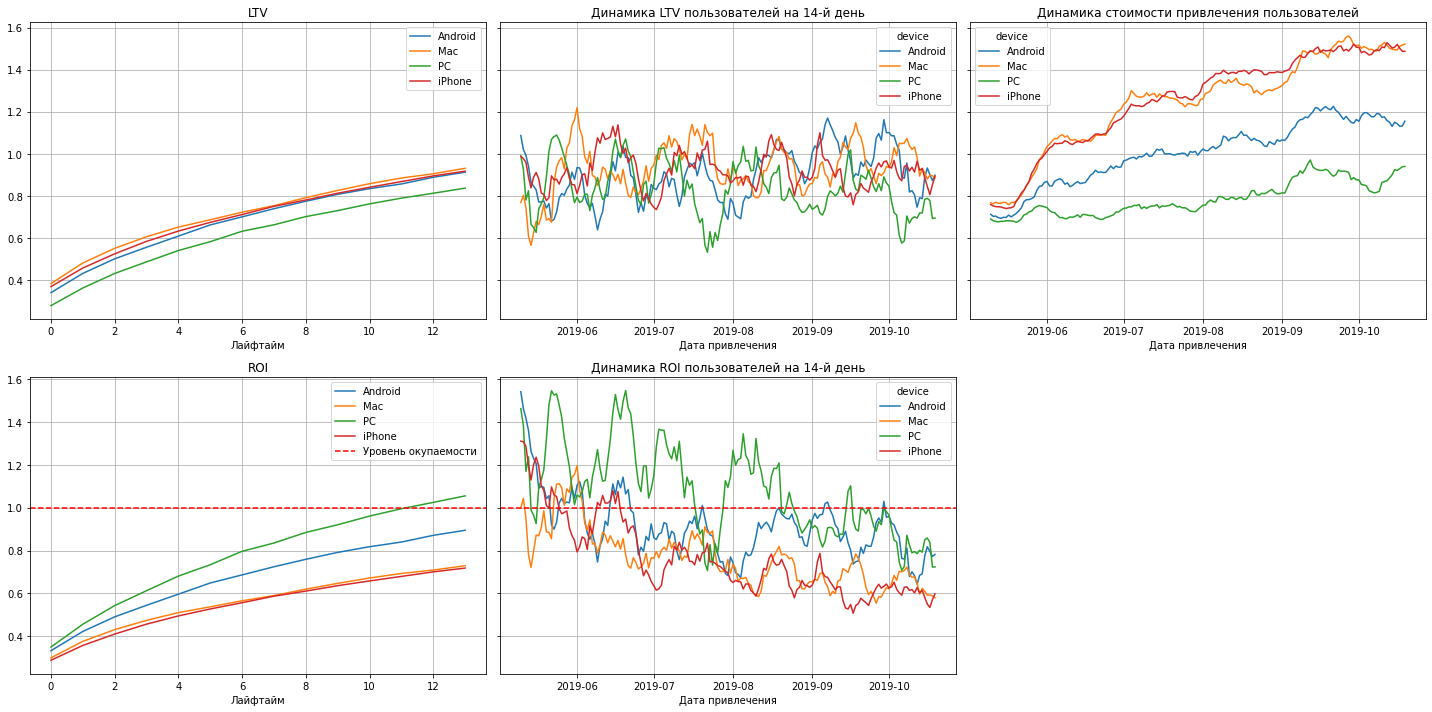

In [35]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=10)

- По LTV iPhone, Mac и Android в лидерах, PC отстает. Однако в динамике видно, что у лидеров есть проблемы. В сентябре LTV пользователей iPhone падал больше других. У PC "провалы" в июля е октябре
- PC окупаемося, при этом iPhone и Mac окупаются пока на 75%, однако также отметим, что стоимость привлечения по этим устройстам растет быстрее остальных
- В динамике ROI видно, что оукпаемость по iPhone и Mac упала ниже уровня в июле и дальше к уровню не возвращалась. Падала окупаемость и по другим устройствам, так что можно отметить скорее тренд в целом, нежели отдельные устройства, показатели PC выглядят лучше.

**1.3 Окупаемость рекламы с разбивкой по каналам**

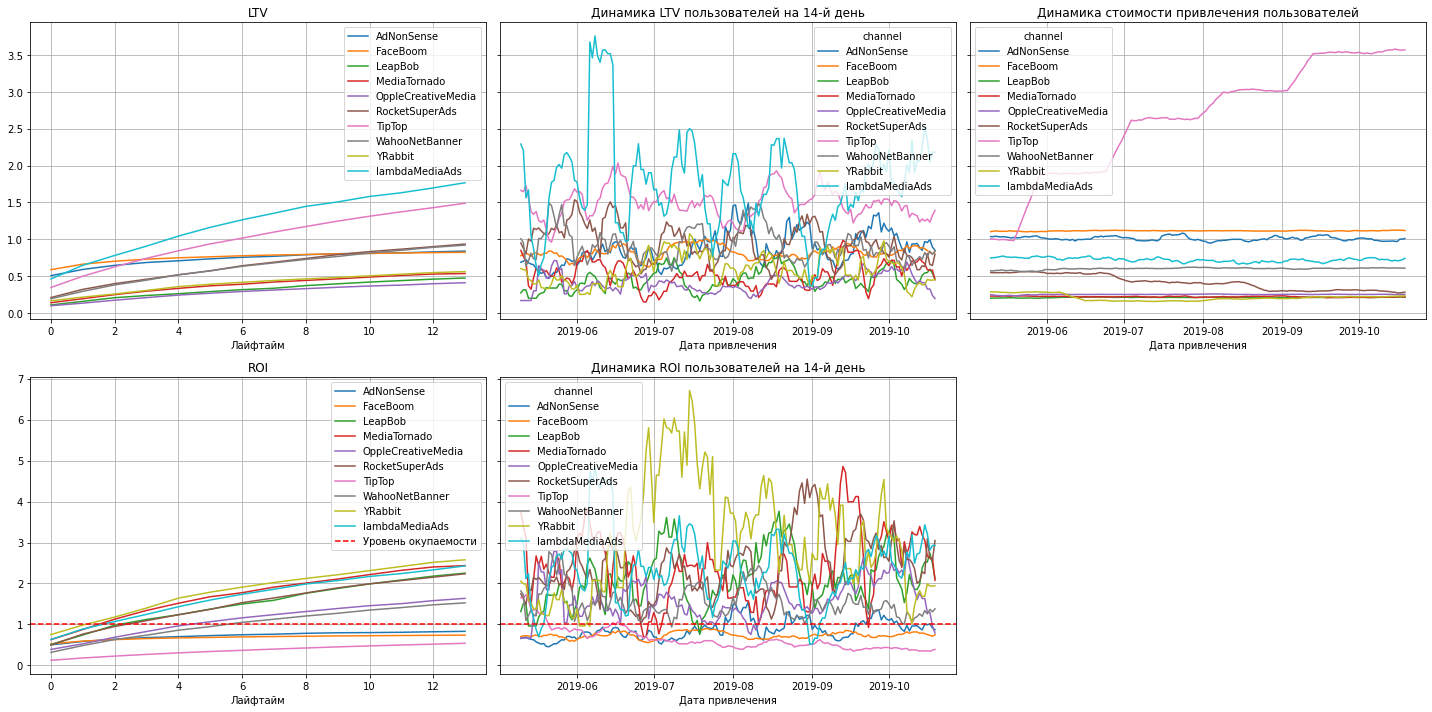

In [36]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=10)

 - По "пожизненной стоимости" лидеры lambda и TipTop, средний рост у FaceBoom и AdNonSense, а в октябре их обогнали еще 2 канала
 - Несмотря на лидерство lambda в динамике показывала и падения (как впрочем и остальыне), а вот в июне был резкий рост, привлекли больше "качественных" клиентов
 - По графику ROI можно заключить, что в лидерах каналы YRabbit, MediaTornado и lambda. Собственно, бОльшая часть каналов из списка окупается. Не окупаются на 100% только 3: FaceBoom, AdNonSense и TiTop. Помним, что среди них два лидера по потреблению рекламного бюджета, поэтому этим каналам нужно принести много платящих, прежде чем они начнут окупаться. Интересно, есть ли у маркетингового отдела заявленный срок окупаемости на каждый канал.
 - В динамике ROI видно, что YRabbit никогда не уходил ниже линии окупаемости (самым сильным месяцем по окупаемости YRabbit стал июль), а TipTop и FaceBoom уже ожидаемо находятся ниже уровня.

**1.4 Окупаемость рекламы с разбивкой по странам**

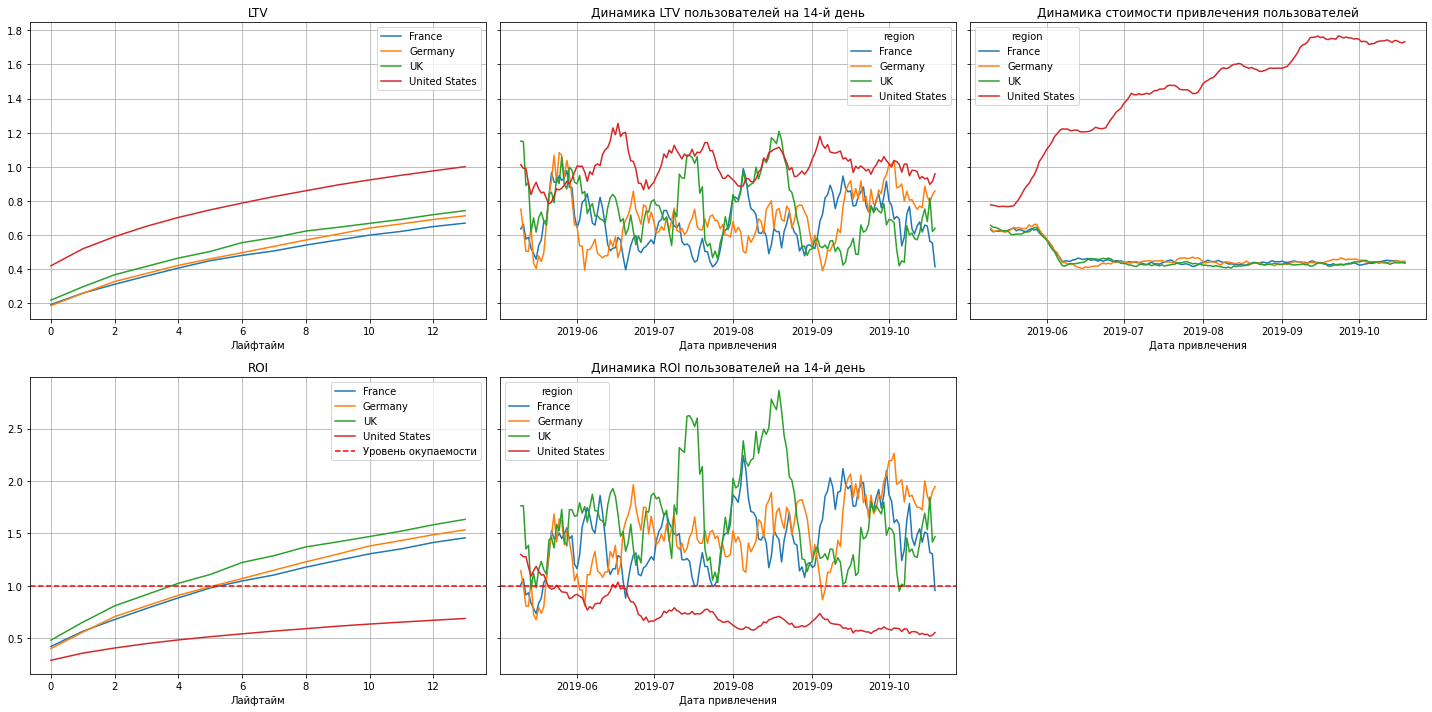

In [37]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)
plot_ltv_roi(ltv, ltv_history, roi, roi_history, 14, window=10)

Выводы:
- По LTV лидер США и динамика не показывает резких падений
- Расходы на рекламу в США, в июне было падение по расходы на все страны кроме США
- США единственная из 4 представленных стран, которая не окупается. По графику ROI есть рост у США, но плавный, и на данный момент окупаются затраты на США примерно на 80%, при этом у остальных стран хорошие показатели окупаемости - у Великобритании(лидера) 200%
- В динамике ROI негативно выделяется США - уходят за линию в июне и дальше плавно падает

Рассмотрим также графики конверсии и удержания 

**2.1 Конверсия и удержание по устройствам**

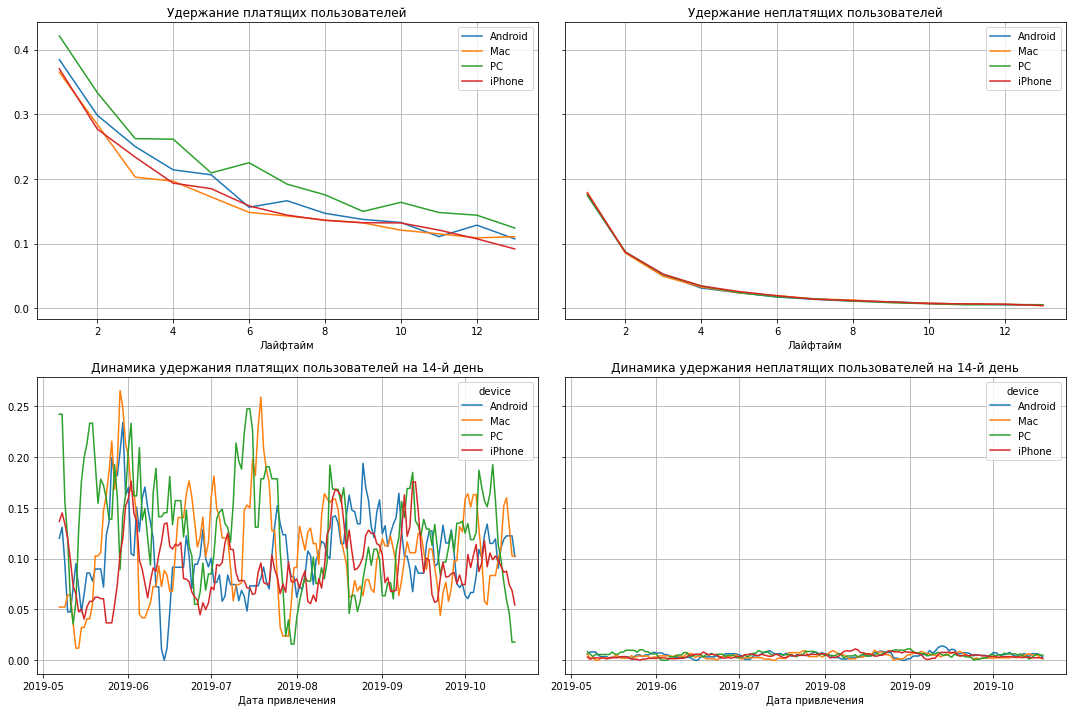

In [38]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)
plot_retention(retention, retention_history, 14, window=7)

По графикам удержания можно следать следующие выводы:
- По удержанию лучшие показатели у PC
- Динамика удержания неплатящих пользователей выглядит стабильно. Количество неплатящих пользвоателей больше, поэтому не удивительно
- Самые "качественные" пользователи по PC были привлечены в мае и июле

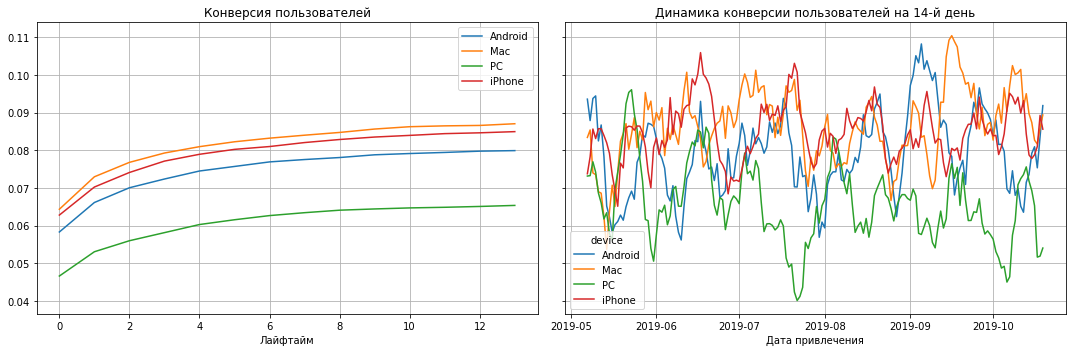

In [39]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)
plot_conversion(conversion, conversion_history, 14, window=7)

- Начиная с июня коверсия растет слабо
- Максимальные значения конверсии по Android и Mac были в сентябре

**2.2 Конверсия и удержание по странам**

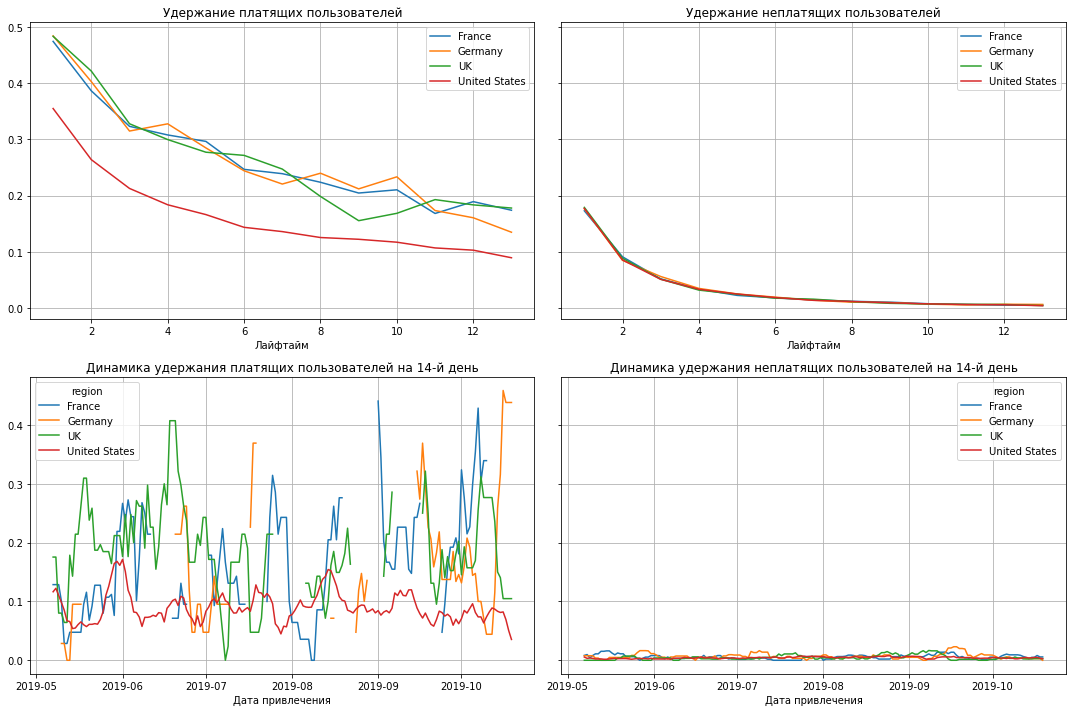

In [40]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)
plot_retention(retention, retention_history, 14, window=7)

- Графики по неплатящим показывают примерно одинаковое положение удержания по странам
- В динамике в худшую сторону выражен график США

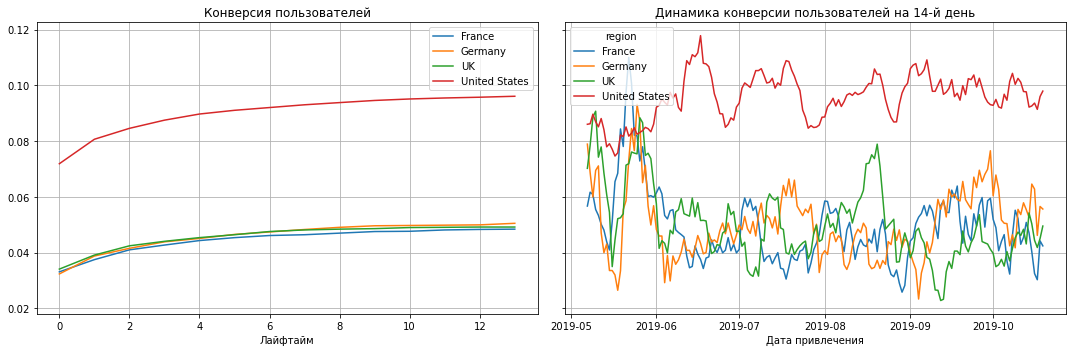

In [41]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)
plot_conversion(conversion, conversion_history, 14, window=7)

- Можно сказать, что график нормальный - конверсия растет, хотя со второго месяца рост слабый
- Явный лидер США, на эту страну приходится и больше всего пользователей
- В динамике самый сильный рост конверсии был у США в июне, у других стран в мае

**2.3 Конверсия и удержание по рекламным каналам**

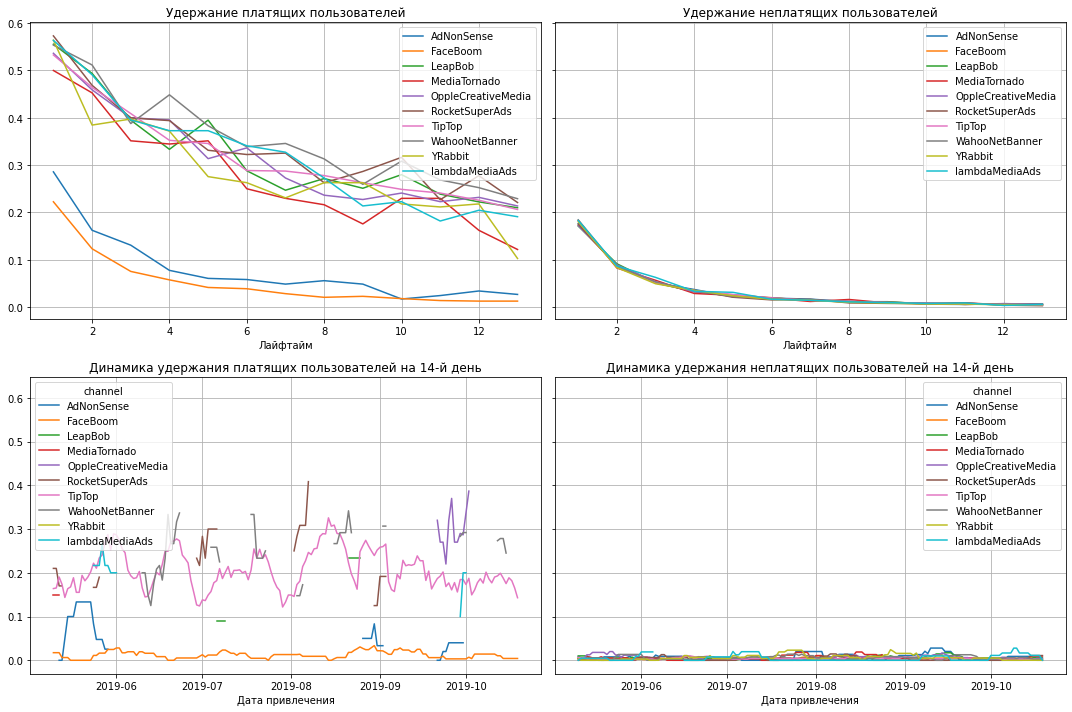

In [42]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)
plot_retention(retention, retention_history, 14, window=10)

- График удержания покупателей по каналам AdNonSense и FaceBoom напоминают график удержания неплатящих пользователей
- В динамике удержания FaceBoom также показывает не сильно лучше результат, чем в целом динамика неплатящих

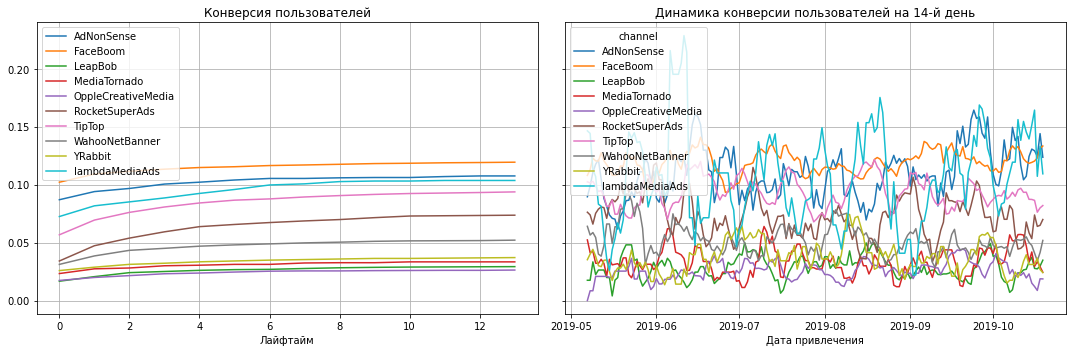

In [43]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)
plot_conversion(conversion, conversion_history, 14, window=7)

- По показателю конверсия лидируют FaceBoom,AdNonSense,lambda и TipTop. И конверсия показывает рост только в самом начале, далее рост практически отсутствует
- В динамике видно, как выделяется канал lambda. Сильный рост в июне, также в в августе

**Общий вывод по Шагу 5**

Проанализировав графики, можно сделать слующие выводы:
- Реклама не окупается, на данный момент можно зафиксировать окупаемость на 80%
- По устройствам больше всего затрат на iPhone и Mac, при этом по ним нет окупаемости. У PC есть. По удержанию PC также имеет лучшие показатели, тем не менее худшие в конверсии. В динамике есть падение окупаемости по всем
- Из рекламных каналов можно выделить lambdaMediaAds - положительная динамика, лидерство по LTV, в лидерах по окупаемости. В целом большиство каналов окупается, за исключением трех: FaceBoom, AdNonSense, TipTop. FaceBoom также показывает худшие значения по удержанию. Конверсия тем не менее у этого канала выше всех, однако стоит заметить, что она практически не растет
- По странам: США едиснтвенная их четырех стран, которая не окупается. В динамике наблюдается падение, с июня ниже уровня окупаемости. Опять же по США самая высокая конверсия, но рост очень слабый


# Шаг 6. Выводы
Отсюда видим, что
- пользвоатели из США, 
- пользователи iPhone и Mac, а также 
- реламные каналы FaceBoom и TipTop 
могут снижать окупаемость.

Конечно, нужно учитывать количество пользователей. Большинство используют iPhone, большинство пользователей из США и TipTop и FaceBoom самые "людные" каналы. И поэтому резонны более низкие показатели и больший срок окупаемости, к примеру.

И тем не менее довольно странно, что по PC есть окупаемость, при том приличная, а по Mac и iPhone нет. Возможно, причина таких показателей в различии ПО приложения для разных платформ.

Хотелось бы обратить внимание маркетингового отдела на:
- рекламные компании в FaceBoom, TipTop и, для сравнения, lambda. Первые две забирают львинуюю долю рекламного бюджета - около 80%(расходы на TipTop выросли шестикратно), при этом обе не показывают окупаемости. К тому же стоимость рекламы на TipTop самая дорогая - в среднем 2.8 за привлечение одного клиента. Конверсия высокая, однако с июня она не растет. В это же время lamdba имея относительно небольшой бюджет (это понятно, там пользователей в 10 раз меньше), имеет рост конверсии и окупаемости
- таргетирование рекламных компаний по географии. Расходы на рекламу в странах кроме США сократились в июне, а на США в течение всего периода росли. У стран кроме США хорошая окупаемость, по Великобритании 200% к примеру
- отсутсвие роста или слабый рост конверсии, начиная с июня
- корректность работы приложения на разных платформах(Mac и iPhone прежде всего), особенно в части удобства и скорости совершения покупки